# Twitter Sentiment Analysis
[link](https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis/notebook)

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# # Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2023-07-18 23:02:39.958871: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 23:02:40.042620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-18 23:02:40.043625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 23:02:41.411917: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from pathlib import Path
import seaborn as sns
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv(r'../data/training.1600000.processed.noemoticon.csv.zip',encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

In [4]:
df.sample(5)

,target,ids,date,flag,user,text
893489,4,1691900289,Sun May 03 18:51:05 PDT 2009,NO_QUERY,dailyPRIME,@JONASMileyDemi Woo I'm glad someone finally v...
273327,0,1990375965,Mon Jun 01 04:41:58 PDT 2009,NO_QUERY,Luke_Scott,Back home for atleast the next two weeks. And ...
766201,0,2299789597,Tue Jun 23 13:20:54 PDT 2009,NO_QUERY,stickart,http://tinyurl.com/m5care - &quot;Ed McMahon D...
511924,0,2190016821,Tue Jun 16 01:31:51 PDT 2009,NO_QUERY,JadeLee_,@Georgesampson nice one i've got mine next yea...
567229,0,2207116773,Wed Jun 17 07:30:26 PDT 2009,NO_QUERY,simpleskye,is sad that iPhone 3.0 is not available yet. I...


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df['target'] = df['target'].map(decode_sentiment)   

In [6]:
df.target.sample(5)

826454    POSITIVE
488153    NEGATIVE
799004    NEGATIVE
13192     NEGATIVE
100948    NEGATIVE
Name: target, dtype: object

<Axes: xlabel='target', ylabel='count'>

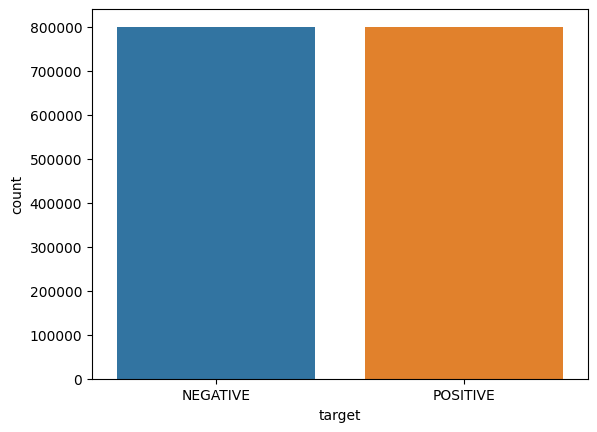

In [7]:
import seaborn as sns
sns.countplot(data=df,x='target')

## Preprocess


In [6]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# stop_words_rus = stopwords.words("russian")
# stemmer_r = SnowballStemmer('russian')

In [10]:
# stemmer.stem('prefferencies')

'preffer'

In [7]:
# Remove link,user and special characters
TEXT_CLEANER_RE = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]+"
def preprocess_text(text_input, stem=False):
    text = re.sub(
        TEXT_CLEANER_RE, 
        ' ', 
        str(text_input).lower()).strip()
    tokens = [ ]
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [8]:
%%timeit
df_1 = df.copy()


530 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
df.text = df.text.apply(lambda x: preprocess_text(x))
df.text.sample(5)

45.9 s ± 536 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# df.text.apply(lambda x: len(x) > df.text.apply(len).quantile(0.9))

# NLP

In [11]:
# split by train, test
TRAIN_SIZE = 0.8
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print(f"""
    TRAIN size:{len(df_train)} \n
    TEST size: {len(df_test)} """)


    TRAIN size:1280000 

    TEST size: 320000 


In [15]:
%%time
documents = [_text.split() for _text in df_train.text]
len(documents)

CPU times: user 3.94 s, sys: 616 ms, total: 4.55 s
Wall time: 4.56 s


1280000

In [12]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [13]:
w2v_model = gensim.models.word2vec.Word2Vec(
    vector_size=W2V_SIZE, 
    window=W2V_WINDOW, 
    min_count=W2V_MIN_COUNT, 
    workers=12)

2023-07-18 23:14:53,514 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2023-07-18T23:14:53.514394', 'gensim': '4.3.1', 'python': '3.10.6 (main, Nov 10 2011, 15:00:00) [GCC 12.2.0]', 'platform': 'Linux-6.2.6-76060206-generic-x86_64-with-glibc2.35', 'event': 'created'}


In [16]:
w2v_model.build_vocab(documents)   

2023-07-18 23:15:22,861 : INFO : collecting all words and their counts
2023-07-18 23:15:22,862 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-07-18 23:15:22,888 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2023-07-18 23:15:22,911 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2023-07-18 23:15:22,933 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2023-07-18 23:15:22,974 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2023-07-18 23:15:23,006 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2023-07-18 23:15:23,049 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2023-07-18 23:15:23,087 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2023-07-18 23:15:23,123 : INFO : PROGRESS: at s

In [17]:
words = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 30369


In [18]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2023-07-18 23:15:44,176 : INFO : Word2Vec lifecycle event {'msg': 'training model with 12 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2023-07-18T23:15:44.176006', 'gensim': '4.3.1', 'python': '3.10.6 (main, Nov 10 2011, 15:00:00) [GCC 12.2.0]', 'platform': 'Linux-6.2.6-76060206-generic-x86_64-with-glibc2.35', 'event': 'train'}
2023-07-18 23:15:45,206 : INFO : EPOCH 0 - PROGRESS: at 8.04% examples, 650812 words/s, in_qsize 19, out_qsize 4
2023-07-18 23:15:46,209 : INFO : EPOCH 0 - PROGRESS: at 17.03% examples, 693628 words/s, in_qsize 23, out_qsize 0
2023-07-18 23:15:47,254 : INFO : EPOCH 0 - PROGRESS: at 25.37% examples, 681021 words/s, in_qsize 23, out_qsize 0
2023-07-18 23:15:48,292 : INFO : EPOCH 0 - PROGRESS: at 34.03% examples, 682283 words/s, in_qsize 23, out_qsize 0
2023-07-18 23:15:49,299 : INFO : EPOCH 0 - PROGRESS: at 42.24% examples, 680379 words/s, in_qsize 22, out_qsize 1
2023-07-18 23:15

(263123893, 295270528)

In [59]:
w2v_model.wv.most_similar("tesla")


[('engine', 0.31074681878089905),
 ('opensource', 0.30869194865226746),
 ('bmw', 0.30633941292762756),
 ('routes', 0.3048129975795746),
 ('estimated', 0.30316993594169617),
 ('solar', 0.29981598258018494),
 ('chevy', 0.2951294779777527),
 ('honda', 0.2947421073913574),
 ('exit', 0.29344940185546875),
 ('hosted', 0.29268109798431396)]

## Kearas text

In [28]:
# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [26]:
%%timeit
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size= len(tokenizer.word_index) + 1
print(f'TOTAL WORDS: {vocab_size}')

TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
TOTAL WORDS: 290419
22.2 s ± 1.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


21.9 s ± 828 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']